写在前面，由于部分观众可能刚刚接触python，对jupyter不熟悉，加上视频中jupyter已经过定制化，修改过执行目录和主题，对不熟悉jupyter的观众十分不友好。

_如果您已经熟悉 jupyter 的使用，可以直接略过本说明。_

anaconda安装后，不管安装到哪个盘，jupyter的运行目录都是 C:\User\用户名\
具体是如何修改的，可以参考这篇博客: https://www.cnblogs.com/gbgx/p/11291761.html

在浏览器页面新建Notebook ipykernel，就会创建一个.ipynb结尾的文件，这个文件存储了笔记本的代码和输出，没有在运行时可以自由移动。

在笔记本里执行命令，也是默认以笔记本所在的文件夹为工作目录。比如使用speechbrain后生成缓存，就存在当前笔记本的工作目录下。

如何定制jupyter的主题，可以看这个: https://zhuanlan.zhihu.com/p/54397619。
可以根据个人喜好配置界面

### 将vgmstream解码后的文件重命名一遍

In [6]:
import os

files = os.listdir("D:\\dataset\\yuanshen")
len(files)

2030

In [3]:
print(files[0])
print(files[0][:-4]) # 只取倒数第四个字符以前的

'1001 00001.wav'

In [4]:
import shutil

root = "D:\\dataset\\yuanshen\\"
for file in files:
    shutil.move(root+file, root+file[:-4])

#### 语音重采样

In [2]:
import os
import librosa
import soundfile
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

D:\ML\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


如果缺少某个库，在笔记本里直接使用  !pip install ... 命令安装

torch 和 torchaudio 库是例外，需要到pytorch的官网 https://pytorch.org/ 往下滑，找到下图这样的，按自己的电脑选择对应的选项

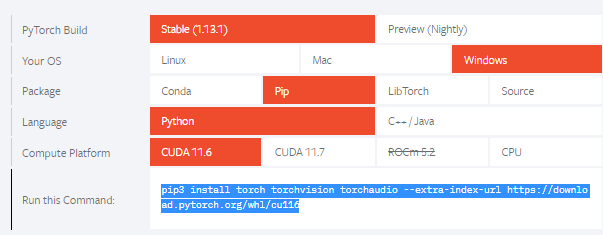

复制run this command 给出的命令，回来jupyter粘贴，前面加个感叹号然后执行。就像这样:

!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
### 如果您本地有16G显存的Nvidia显卡，并且打算在本地训练VITS，请直接使用下面这个支持混合精度加速的torch版本。
# !pip3 install torch==1.13.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
import torchaudio

wav, sr = torchaudio.load('D:\\dataset\\yuanshen\\1001 00001.wav')
sr  # 采样率48000  -> 目标 16000

48000

In [5]:
def resample_all(src_dir, dst_dir, files, origin_sr=48000, target_sr=16000):
    # src_dir: 原来的wav文件的文件夹路径
    # dst_dir: 目标文件夹的路径，没有则会创建文件夹
    # files: 需要转换的wav文件的名字，列表形式
    # origin_sr: 原来的wav文件的采样率, 默认是48k
    # target_sr: 需要转换到的wav文件的采样率, 默认是16k
    print('resampling dir: '+src_dir)
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    cnt = 0
    for fname in files:
        if not fname.endswith('.wav'): continue
        y, sr = librosa.load(os.path.join(src_dir, fname), sr=origin_sr)
        y_hat = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        soundfile.write(os.path.join(dst_dir, fname), y_hat, target_sr)
        cnt+=1
        print(f'\r count: {cnt}', end='', flush=True)  # 反复在同一行刷新日志
    print('') # 最后换行

In [7]:
resample_all("D:\\dataset\\yuanshen", "D:\\dataset\\yuanshen16k", files) # 对files执行重采样

resampling dir: D:\dataset\yuanshen
 count: 1079

KeyboardInterrupt: 

#### 声纹编码

In [ ]:
!pip install soundfile

In [ ]:
!pip install speechbrain

In [1]:
import torch
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [11]:
classifier.eval()

def get_embeds(paths, rest=False, log=False):
    embeddings = []
    cnt = len(paths)
    for path in paths:
        if not path.endswith('.wav'): continue
        y, sr = librosa.load(path, sr=16000)
        with torch.no_grad():
            embed = classifier.encode_batch(torch.tensor(y))[0, 0, :]
        embeddings.append(embed)
        
        if log:
            cnt -= 1
            print(f'\r{cnt} left.  ', end='', flush=True)
        if rest:
            time.sleep(0.15)
        
    return torch.stack(embeddings, dim=0)

In [13]:
from glob import glob
filepaths = glob('D:\\dataset\\yuanshen16k\\*.wav')  # 获取特定文件夹下所有wav文件的路径列表
filepaths[:10]

['D:\\dataset\\yuanshen16k\\1001 00001.wav',
 'D:\\dataset\\yuanshen16k\\1001 00002.wav',
 'D:\\dataset\\yuanshen16k\\1001 00003.wav',
 'D:\\dataset\\yuanshen16k\\1001 00004.wav',
 'D:\\dataset\\yuanshen16k\\1001 00005.wav',
 'D:\\dataset\\yuanshen16k\\1001 00006.wav',
 'D:\\dataset\\yuanshen16k\\1001 00007.wav',
 'D:\\dataset\\yuanshen16k\\1001 00008.wav',
 'D:\\dataset\\yuanshen16k\\1001 00009.wav',
 'D:\\dataset\\yuanshen16k\\1001 00010.wav']

In [31]:
embeds = get_embeds(filepaths, log=True)  # 生成声纹编码
embeds.shape  # 编码大小, 没有错误的话应该是: [文件个数, 192]

torch.Size([1079, 192])

In [52]:
torch.save(embeds, 'embeds.pt')     # 临时保存，以备后用。编码除了用余弦复杂度来寻找相同说话人，还可以用机器学习的方法自动分类，精度上可能低一些。下拉到笔记本末尾查看机器学习的分类方法。
# embeds = torch.load('embeds.pt')  # 保存后可以用这种方法加载 

In [19]:
for i, f in enumerate(filepaths):  
    # 找一组语音文件名在filepaths中对应的下标。
    # 也可以按文件名排序后自己听，记录第几个文件是自己想要的。从0开始数。
    if f.split('\\')[-1] in ['1001 00001.wav', '1001 00006.wav', '1001 00023.wav']:
        print(i)

0
5
22


#### 用余弦相似度对比正样本和负样本

In [62]:
def vec_mod(a):
    # 计算两个向量的模
    return torch.sqrt(torch.sum(a*a, axis=1, keepdims=True))

def cos_sim(a, b):
    # 计算两组tensor(横向量纵向排列)的余弦相似度
    # input: a: n*k, b: m*k
    # output: c: n*m
    mod1, mod2 = vec_mod(a), vec_mod(b)
    fenzi = a @ b.T
    fenmu = mod1 @ mod2.T
    return fenzi/fenmu

def get_rank(a, pos=[], neg=[]):
    # a: 声纹编码
    # pos: 正样本的下标列表
    # neg: 负样本的下标列表
    ref_embeds = torch.stack([embeds[i] for i in pos], dim=0)
    sims = torch.mean(cos_sim(ref_embed, embeds), axis=0)
    
    ref_embeds = torch.stack([embeds[i] for i in neg], dim=0)
    sims -= torch.mean(cos_sim(ref_embeds, embeds), axis=0)
    return torch.argsort(sims).numpy()[::-1]

In [82]:
# 所有编码分别跟正样本和负样本计算余弦相似度，获取相似度排序结果
# 这里pos和neg里面的索引越精简越好，要找有代表性的样本
rank = get_rank(embeds, pos=[0, 5, 22], neg=[1, 4, 686, 195, 788, 421, 1073])

rank[:10] # 查看排序结果的前十个

array([  0,   5, 677,  22, 238,  29, 211, 454,  27, 284], dtype=int64)

In [81]:
from IPython.display import display, Audio

si = 180  # 检查排在si到si+10的语音，确定都是正确类别后，再运行下一个单元格
selects = rank[si:si+10]
for idx in selects:
    wave, sr = librosa.load(filepaths[idx], sr=22050)
    print(idx)
    display(Audio(wave, rate=sr))

367


588


63


406


696


103


79


310


484


1073


In [ ]:
import shutil
# 先不要运行这个，等你确定好了前n个语音的声纹都是想要的，再来运行。
n = 190 # 这个n根据实际情况修改
selects = rank[:n]
for idx in selects:
    src_file = filepaths[idx]
    dst_file = "D:\\dataset\\paimon\\"+src_file.split('\\')[-1]
    shutil.move(src_file, dst_file)

#### 语音转文本

In [91]:
# 一 获取百度的token
import time
import json
from urllib.request import urlopen
from urllib.request import Request
from urllib.error import URLError
from urllib.parse import urlencode

timer = time.perf_counter

API_KEY = 'xxxx'  # 演示用的api接口，需要的可以去申请，也可以用我视频里的，反正够用。
SECRET_KEY = 'xxxx'  # 这里是要修改的
CUID = '123456PYTHON'
RATE = 16000;  # 采样率固定16k
DEV_PID = 1537  # 1537 表示识别普通话，使用输入法模型。根据文档填写PID，选择语言及识别模型
SCOPE = 'audio_voice_assistant_get'  # 有此scope表示有asr能力，没有请在网页里勾选，非常旧的应用可能没有
TOKEN_URL = 'http://aip.baidubce.com/oauth/2.0/token'

class DemoError(Exception):
    pass

def refresh_token():
    params = {'grant_type': 'client_credentials',
              'client_id': API_KEY,
              'client_secret': SECRET_KEY}
    post_data = urlencode(params)

    post_data = post_data.encode('utf-8')
    req = Request(TOKEN_URL, post_data)
    try:
        f = urlopen(req)
        result_str = f.read()
    except URLError as err:
        print('token http response http code : ' + str(err.code))
        result_str = err.read()

    result_str = result_str.decode()

    print(result_str)
    result = json.loads(result_str)
    print(result)
    if ('access_token' in result.keys() and 'scope' in result.keys()):
        if SCOPE and (not SCOPE in result['scope'].split(' ')):  # SCOPE = False 忽略检查
            raise DemoError('scope is not correct')
        print('SUCCESS WITH TOKEN: %s ; EXPIRES IN SECONDS: %s' % (result['access_token'], result['expires_in']))
        return result['access_token']
    else:
        raise DemoError('MAYBE API_KEY or SECRET_KEY not correct: access_token or scope not found in token response')


token = refresh_token()

{"refresh_token":"25.0c5ba3f4e0ad26e19fcc5844cc9180ef.315360000.1990333181.282335-29860332","expires_in":2592000,"session_key":"9mzdAvRR9\/sM2+tpRqwUDxZdL0J4N9Tnmra9S3WvhPckl\/eAEve\/ACYoChBO3nXA7vihw+dDuVKYgGc2Xyd3BmyqeLA2zA==","access_token":"24.96555d82f5407728a36a5228e4b8a640.2592000.1677565181.282335-29860332","scope":"audio_voice_assistant_get brain_enhanced_asr audio_tts_post brain_speech_realtime public brain_all_scope brain_asr_async wise_adapt lebo_resource_base lightservice_public hetu_basic lightcms_map_poi kaidian_kaidian ApsMisTest_Test\u6743\u9650 vis-classify_flower lpq_\u5f00\u653e cop_helloScope ApsMis_fangdi_permission smartapp_snsapi_base smartapp_mapp_dev_manage iop_autocar oauth_tp_app smartapp_smart_game_openapi oauth_sessionkey smartapp_swanid_verify smartapp_opensource_openapi smartapp_opensource_recapi fake_face_detect_\u5f00\u653eScope vis-ocr_\u865a\u62df\u4eba\u7269\u52a9\u7406 idl-video_\u865a\u62df\u4eba\u7269\u52a9\u7406 smartapp_component smartapp_searc

In [94]:
ASR_URL = 'http://vop.baidu.com/server_api'
FORMAT = 'wav'

def resample(fname):
    y, sr = librosa.load(os.path.join(fpath, fname), sr=22050)
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    soundfile.write('tmp.wav', y, 16000)

def asr(fname):
    # convert 16k samplerate wave file to text
    # resample(fname)
    with open(fname, 'rb') as speech_file:
        speech_data = speech_file.read()
    length = len(speech_data)
    if length > 2296044:  # 过滤太长的语音，防止api罢工
        print('ignore '+fname)
        return '-'
    elif length == 0:
        raise DemoError('file %s length read 0 bytes' % fname)
    # 记得先在上面获取token
    params = {'cuid': CUID, 'token': token, 'dev_pid': DEV_PID}
    params_query = urlencode(params)
    headers = {
        'Content-Type': 'audio/' + FORMAT + '; rate=' + str(RATE),
        'Content-Length': length
    }

    # print post_data
    req = Request(ASR_URL + "?" + params_query, speech_data, headers)
    try:
        f = urlopen(req)
        result_str = f.read()
    except  URLError as err:
        print('asr http response http code : ' + str(err.code))
        result_str = err.read()
        print(result_str)
        return '-'
    result = json.loads(str(result_str, 'utf-8'))
    if result['err_msg'] == 'success.':
        return result['result'][0]
    else:
        return '-'

fpath = 'D:\\dataset\\paimon\\*.wav'  # 根据实际情况，选择你存放16k采样率语音的文件夹，* 不要漏了

for audio_file in glob(fpath): # 对每个语音文件进行语音转文字，结果保存在笔记本同文件夹下的 result2.txt 内
    result = asr(audio_file)
    with open("result2.txt", "a", encoding='utf-8') as of:
        data = '|'.join([audio_file, result])
        of.write(data+'\n')
    print(f'\r{result}', end='', flush=True)

机器学习分类方法补充：

> 可视化：PCA降维，加KMeans无监督聚类<br/>
> 直接分类：只用KMeans就行

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)
x_min_p2, x_max_p2 = np.min(X_pca,0), np.max(X_pca,0)
X_pca = (X_pca-x_min_p2)/(x_max_p2-x_min_p2)

# for i in range(len(X_pca)):
    # plt.text(X_pca[i, 0], X_pca[i, 1], files[i][:-4]);
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [ ]:
from sklearn.cluster import KMeans # 这些库不用手动安装，Anaconda自带的

kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(embeddings)
labels = kmeans.labels_

In [ ]:
colors = ['b','g','r','c','m','y','k','purple','coral','lime']
plt.figure(figsize=(6,6))
for i, coord in enumerate(X_pca):
    # plt.scatter(coord[0], coord[1], c=colors[labels[i]])
    plt.text(coord[0], coord[1], files[i][:-4], c=colors[labels[i]]);
plt.title('Reduced dimension of speaker embedding')
plt.show()

In [ ]:
import shutil
def ensure_path(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def dispatch_files(path, prefix, files, labels):
    for i, fname in enumerate(files):
        dst_path = os.path.join(path, str(labels[i]))
        ensure_path(dst_path)
        src_file = os.path.join(path, fname)
        dst_file = os.path.join(dst_path, prefix+' '+fname)
        shutil.move(src_file, dst_file)